# Diabetes Risk Classification (BRFSS)

Exploratory data analysis (EDA) and baseline KNN modeling for predicting diabetes risk using the CDC BRFSS 2015 diabetes health indicators dataset. The flow covers data understanding, preparation, modeling (KNN with and without PCA), and evaluation with accuracy, precision, recall, F1, and ROC-AUC.


## 0. Setup
- BRFSS file expected at `data/brfss/diabetes_binary_health_indicators_BRFSS2015.csv`.
- Install dependencies: `pip install pandas numpy seaborn matplotlib scikit-learn`.


In [33]:
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
import numpy as np
np.seterr(all="ignore")  # suppress runtime warnings during PCA
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    RocCurveDisplay,
    ConfusionMatrixDisplay,
)

sns.set_theme(style='ticks', palette='deep')


In [34]:
# Resolve project root whether running from repo root or notebooks/
PROJECT_ROOT = Path.cwd()
if PROJECT_ROOT.name == 'notebooks':
    PROJECT_ROOT = PROJECT_ROOT.parent

brfss_path = PROJECT_ROOT / 'data/brfss/diabetes_binary_health_indicators_BRFSS2015.csv'

if not brfss_path.exists():
    raise FileNotFoundError(f"BRFSS file not found at {brfss_path.resolve()}")


In [35]:
# Load BRFSS
brfss_raw = pd.read_csv(brfss_path)
print("BRFSS shape", brfss_raw.shape)


BRFSS shape (253680, 22)


## 1. Data Understanding
Review head, class balance, and missingness.


In [36]:
target_col = 'Diabetes_binary'

print(f"Rows: {brfss_raw.shape[0]}, Cols: {brfss_raw.shape[1]}")
if target_col not in brfss_raw.columns:
    raise KeyError(f"Expected target column '{target_col}' missing")

display(brfss_raw.head())
display(brfss_raw[target_col].value_counts(normalize=True).rename('proportion'))
display(brfss_raw.isna().mean().sort_values(ascending=False).head(10))


Rows: 253680, Cols: 22


,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


Diabetes_binary
0.0    0.860667
1.0    0.139333
Name: proportion, dtype: float64

Diabetes_binary    0.0
HighBP             0.0
Education          0.0
Age                0.0
Sex                0.0
DiffWalk           0.0
PhysHlth           0.0
MentHlth           0.0
GenHlth            0.0
NoDocbcCost        0.0
dtype: float64

## 2. Clean and Prepare Features
- Lowercase column names.
- Drop duplicates and rows with all-null predictors.


In [37]:
def clean_columns(df: pd.DataFrame) -> pd.DataFrame:
    return df.rename(columns={c: c.strip().lower() for c in df.columns})

brfss = clean_columns(brfss_raw).rename(columns={target_col.lower(): target_col.lower()})
target = target_col.lower()

brfss = brfss.drop_duplicates()
brfss = brfss.dropna(how='all', subset=[c for c in brfss.columns if c != target])


Predictors: 21


In [ ]:
# Feature engineering: map age codes to human-readable groups
age_map = {
    1: '18-24', 2: '25-29', 3: '30-34', 4: '35-39', 5: '40-44',
    6: '45-49', 7: '50-54', 8: '55-59', 9: '60-64', 10: '65-69',
    11: '70-74', 12: '75-79', 13: '80+'
}
if 'age' in brfss.columns:
    brfss['age_group'] = brfss['age'].map(age_map)

predictors = [c for c in brfss.columns if c != target]
print('Predictors after feature engineering:', len(predictors))


## 3. Exploratory Data Analysis
Class balance and correlation heatmap.


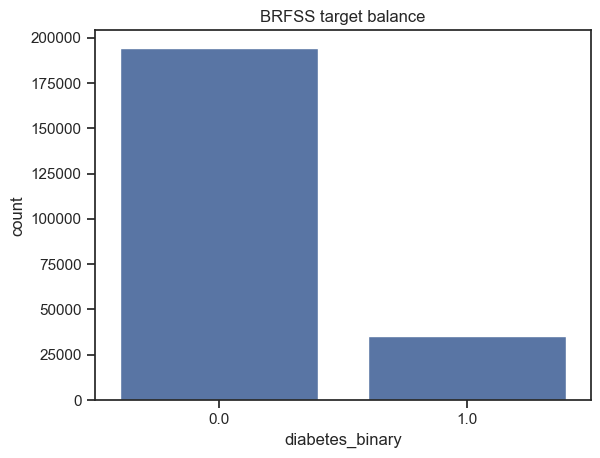

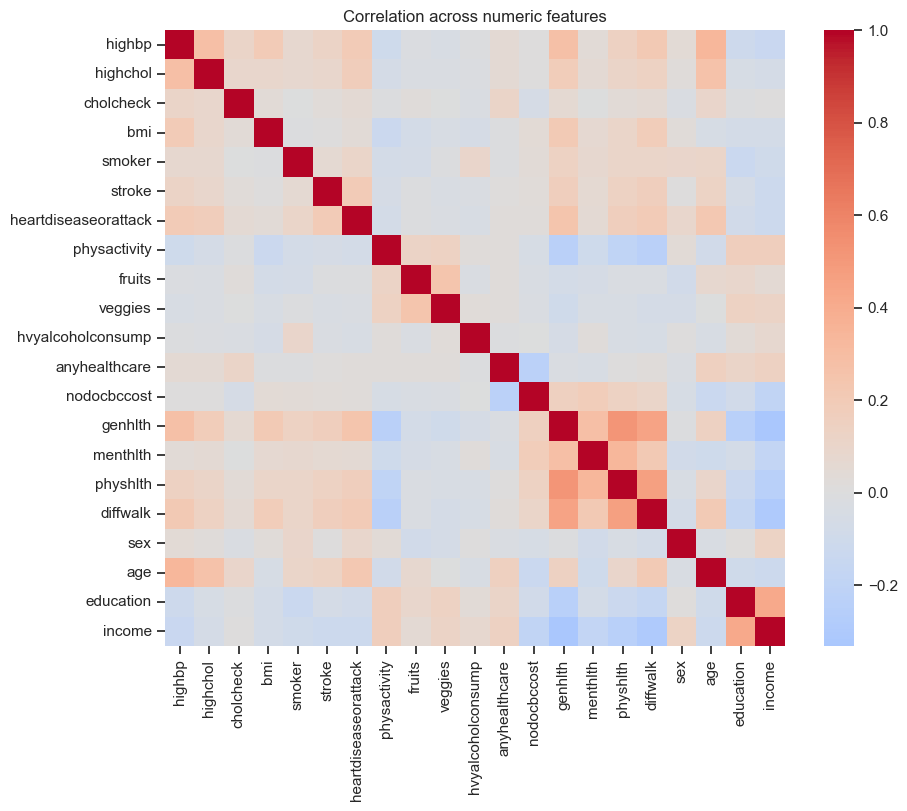

In [44]:
sns.countplot(data=brfss, x=target)
plt.title('BRFSS target balance')
plt.show()

numeric_cols = [c for c in predictors if pd.api.types.is_numeric_dtype(brfss[c])]
corr = brfss[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('Correlation across numeric features'); plt.show()


In [ ]:
# Categorical distribution example (smoker)
if 'smoker' in brfss.columns:
    plt.figure(figsize=(5,4))
    sns.countplot(data=brfss, x='smoker')
    plt.title('Smoking status distribution')
    plt.xlabel('Smoker'); plt.ylabel('Count'); plt.show()


In [ ]:
# Continuous distributions for BMI
fig, ax = plt.subplots(1, 2, figsize=(10,4))
sns.histplot(brfss['bmi'], kde=True, ax=ax[0])
ax[0].set_title('BMI distribution')
ax[0].set_xlabel('BMI')
sns.boxplot(x=brfss['bmi'], ax=ax[1])
ax[1].set_title('BMI boxplot')
plt.tight_layout(); plt.show()


In [ ]:
# Simple outlier check on BMI using IQR
q1, q3 = brfss['bmi'].quantile([0.25, 0.75])
iqr = q3 - q1
lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
outlier_count = ((brfss['bmi'] < lower) | (brfss['bmi'] > upper)).sum()
print(f"BMI outliers (IQR rule): {outlier_count}")
# Clip extreme BMI values to reduce influence on scaling/modeling
brfss['bmi'] = brfss['bmi'].clip(lower, upper)


## 4. Train/Test Split and Preprocessing
- Numeric: median impute + scale.
- Categorical: mode impute + one-hot encode.


In [45]:
X = brfss[predictors]
y = brfss[target].astype(int)

cat_cols = X.select_dtypes(exclude=np.number).columns.tolist()
num_cols = X.select_dtypes(include=np.number).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore")),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


**Primary evaluation metric:** ROC-AUC is used for model selection; accuracy, precision, recall, and F1 are reported for context.

## 5. Baseline KNN (No PCA)
Grid search over `k` with 5-fold CV. Evaluate accuracy, precision, recall, F1, and ROC-AUC.


In [46]:
param_grid = {"knn__n_neighbors": [3, 5, 7, 9, 15]}

knn_pipeline = Pipeline([
    ("prep", preprocessor),
    ("knn", KNeighborsClassifier(weights="distance")),
])

cv_search = GridSearchCV(
    knn_pipeline,
    param_grid=param_grid,
    cv=5,
    scoring="roc_auc",
    n_jobs=1,
)

cv_search.fit(X_train, y_train)
print(f"Best k: {cv_search.best_params_['knn__n_neighbors']}, CV ROC-AUC: {cv_search.best_score_:.3f}")

best_knn = cv_search.best_estimator_

y_pred = best_knn.predict(X_test)
y_proba = best_knn.predict_proba(X_test)[:, 1]

metrics = {
    "accuracy": float(accuracy_score(y_test, y_pred)),
    "precision": float(precision_score(y_test, y_pred)),
    "recall": float(recall_score(y_test, y_pred)),
    "f1": float(f1_score(y_test, y_pred)),
    "roc_auc": float(roc_auc_score(y_test, y_proba)),
}
metrics


Best k: 15, CV ROC-AUC: 0.752


{'accuracy': 0.8395032138577188,
 'precision': 0.4305722288915566,
 'recall': 0.15329819062544522,
 'f1': 0.22609791973103593,
 'roc_auc': 0.7466680439248716}

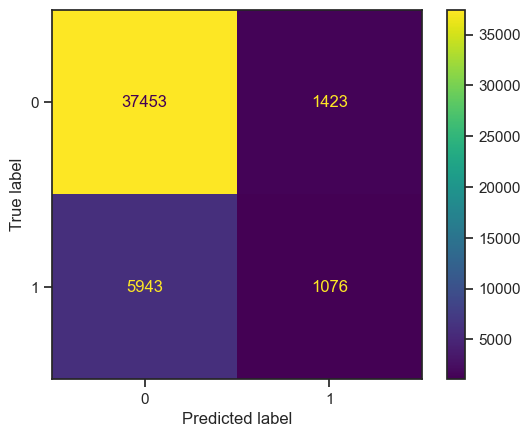

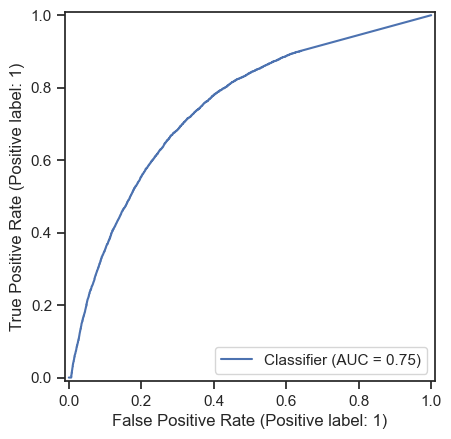

In [47]:
# Plots
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

RocCurveDisplay.from_predictions(y_test, y_proba)
plt.show()


## 6. KNN with PCA
Apply PCA (retain 95% variance) after preprocessing; compare metrics.


In [48]:
pca = PCA(n_components=0.95, random_state=42)

knn_pca = Pipeline([
    ("prep", preprocessor),
    ("pca", pca),
    ("knn", KNeighborsClassifier(weights="distance")),
])

param_grid_pca = {"knn__n_neighbors": [3, 5, 7, 9, 15]}

cv_pca = GridSearchCV(
    knn_pca,
    param_grid=param_grid_pca,
    cv=5,
    scoring="roc_auc",
    n_jobs=1,
)

cv_pca.fit(X_train, y_train)
print(f"Best k (PCA): {cv_pca.best_params_['knn__n_neighbors']}, CV ROC-AUC: {cv_pca.best_score_:.3f}")

best_knn_pca = cv_pca.best_estimator_

y_pred_pca = best_knn_pca.predict(X_test)
y_proba_pca = best_knn_pca.predict_proba(X_test)[:, 1]

metrics_pca = {
    "accuracy": float(accuracy_score(y_test, y_pred_pca)),
    "precision": float(precision_score(y_test, y_pred_pca)),
    "recall": float(recall_score(y_test, y_pred_pca)),
    "f1": float(f1_score(y_test, y_pred_pca)),
    "roc_auc": float(roc_auc_score(y_test, y_proba_pca)),
}
metrics_pca


Best k (PCA): 15, CV ROC-AUC: 0.747


{'accuracy': 0.8392199586011548,
 'precision': 0.42512479201331116,
 'recall': 0.1456047870066961,
 'f1': 0.21691605645760373,
 'roc_auc': 0.7439391629830288}

In [49]:
# Comparison table
comparison = (
    pd.DataFrame([metrics, metrics_pca], index=["knn", "knn_pca"])
    .sort_index(axis=1)
)
display(comparison)


,accuracy,f1,precision,recall,roc_auc
knn,0.839503,0.226098,0.430572,0.153298,0.746668
knn_pca,0.839220,0.216916,0.425125,0.145605,0.743939


## 7. Notes and Next Steps
- Add Decision Tree / Random Forest benchmarks and KNN Regressor.
- Broaden hyperparameter search (distance metrics, weighting), calibrate probabilities, and add permutation importance for interpretability.
- Mitigate class imbalance (weights or resampling) if needed.
- Optional: package an inference API and a Streamlit UI for interactive exploration.
